# Trabalho Prático 2 – Aprendizado Não Supervisionado  
## Segmentação de Clientes com Algoritmos de Clusterização

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juniors719/customer_personality_clustering/blob/main/customer_segmentation.ipynb)

### Equipe:
* Francisco Djalma Pereira da Silva Júnior - 554222
* Francisco Leudes Bezerra Neto - 552478
* Pablo Vinícius da Silva Araújo - 574229

### Objetivo:
O objetivo principal deste projeto é aplicar, comparar e avaliar o desempenho de três algoritmos de clusterização distintos a um conjunto de dados real. O processo envolve todas as etapas de um projeto de ciência de dados, desde a exploração e pré-processamento dos dados até a aplicação dos modelos e a interpretação dos resultados. Ao final, buscamos identificar segmentos (clusters) de clientes com perfis e comportamentos semelhantes, que possam ser utilizados para direcionar estratégias de marketing mais eficazes.

### Descrição do Conjunto de Dados:
Para este trabalho, foi selecionado o dataset **"Customer Personality Analysis"**, disponível publicamente na plataforma Kaggle.
* **Fonte:** [Kaggle - Customer Personality Analysis](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)
* **Amostras:** O dataset original contém **2.240** registros de clientes.
* **Características:** Possui **29** atributos (features) que detalham o perfil de cada consumidor em quatro categorias principais:
    * **Pessoas:** Dados demográficos como ano de nascimento, educação, estado civil e renda.
    * **Produtos:** Gastos em diferentes categorias de produtos (vinhos, carnes, frutas, etc.).
    * **Promoções:** Engajamento dos clientes com campanhas de marketing anteriores.
    * **Lugar:** Canais de compra utilizados pelos clientes (loja física, site, catálogo).

Este conjunto de dados é ideal para a tarefa de clusterização, pois não possui rótulos predefinidos (variável alvo), característica típica de problemas de aprendizado não supervisionado. A riqueza de atributos comportamentais e demográficos torna possível a identificação de segmentos relevantes.

### Algoritmos Utilizados

- **K-Means:** Rápido e eficiente para grandes datasets; assume clusters esféricos e de tamanho similar.
- **Hierárquico (Aglomerativo):** Permite análise mais interpretável via dendrograma; não requer definição prévia do número de clusters.
- **DBSCAN:** Identifica clusters de formatos arbitrários e detecta outliers naturalmente.

### Pipeline do Projeto
1. Importação e visualização inicial dos dados
2. Limpeza de dados e engenharia de atributos
3. Análise exploratória e identificação de outliers
4. Pré-processamento (normalização e codificação)
5. Aplicação dos algoritmos de clusterização
6. Avaliação e comparação dos modelos
7. Visualização com PCA e t-SNE
8. Perfilamento e interpretação dos clusters

### Divisão de Tarefas:

| Etapa                                          | Djalma | Leudes | Pablo |
|------------------------------------------------|:------:|:------:|:-----:|
| Escolha do dataset e definição do problema     |   ✔    |   ✔    |   ✔   |
| Importação e visualização inicial dos dados    |        |   ✔    |       |
| Limpeza e engenharia de features               |   ✔    |        |       |
| Análise exploratória e remoção de outliers     |        |        |   ✔   |
| Pré-processamento (encoding e scaling)         |   ✔    |        |   ✔   |
| Modelagem com K-Means                          |   ✔    |        |       |
| Modelagem com Clusterização Hierárquica        |        |   ✔    |       |
| Modelagem com DBSCAN                           |        |        |   ✔   |
| Avaliação dos modelos                          |   ✔    |   ✔    |   ✔   |
| Visualização dos clusters (PCA e t-SNE)        |   ✔    |        |       |
| Conclusão e perfilamento                       |   ✔    |   ✔    |   ✔   |


# Importação de bibliotecas


In [1]:
# Importação das bibliotecas para manipulação de dados, matemática e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importação das ferramentas de Machine Learning do Scikit-learn que serão usadas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Importação de bibliotecas para ajudar com a visualização e avisos
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage

# --- CONFIGURAÇÕES GERAIS ---
# Ignorar avisos de bibliotecas para um output mais limpo
warnings.filterwarnings("ignore")
# Define um estilo visual padrão para os gráficos
sns.set_style("whitegrid")


import missingno as mn

# Leitura do dataset

In [17]:
try:
    # O arquivo 'marketing_campaign.csv' deve estar na mesma pasta que o seu notebook
    url = "https://raw.githubusercontent.com/juniors719/customer_personality_clustering/refs/heads/main/marketing_campaign.csv"
    df = pd.read_csv(url, sep='\t')
    print("--- Dataset Carregado com Sucesso! ---")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: O arquivo 'marketing_campaign.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo está na mesma pasta que o seu notebook.")

--- Dataset Carregado com Sucesso! ---
O dataset tem 2240 linhas e 29 colunas.


# Primeira análise do dataset

In [3]:
# 1. Visualização das primeiras linhas do dataset
print("\n--- Visualizando as 5 primeiras linhas do dataset: ---")
display(df.head())


--- Visualizando as 5 primeiras linhas do dataset: ---


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Verificação de Tipos de Dados e Contagem de Nulos

O `.info()` nos dá uma visão rápida sobre os tipos de dados e a presença de valores nulos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Estatísticas Descritivas (Numéricas)

O `.describe()` resume as principais métricas estatísticas das colunas numéricas.

In [5]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


### Contagem de Valores Nulos por Coluna

A presença de dados ausentes é um dos problemas mais comuns em projetos de ciência de dados. É crucial identificá-los e tratá-los corretamente, pois a maioria dos algoritmos de Machine Learning não funciona com valores nulos.

**O Impacto dos Dados Ausentes:**

- **Redução do Poder Estatístico:** A ausência de dados diminui o tamanho da amostra, o que pode enfraquecer os resultados de testes estatísticos e a confiança nos modelos.
- **Viés nos Resultados:** Se os dados não estiverem faltando de forma completamente aleatória, a sua ausência pode introduzir um viés significativo. Por exemplo, se pessoas com renda mais baixa tendem a não informar sua renda, qualquer análise sobre o impacto da renda no consumo será distorcida.
- **Problemas Técnicos:** Como mencionado, algoritmos como k-Means param ou geram erros ao encontrar valores nulos.

Vamos agora visualizar detalhadamente onde estão os nossos dados ausentes.

In [6]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percentage], axis=1, keys=['Total', 'Porcentagem'])

print("\n\n--- Análise de Dados Ausentes por Coluna ---")
missing_values = missing_data(df)
display(missing_values.style.background_gradient(cmap='Reds'))



--- Análise de Dados Ausentes por Coluna ---


,Total,Porcentagem
Income,24,1.071429
ID,0,0.000000
Year_Birth,0,0.000000
Education,0,0.000000
Marital_Status,0,0.000000
Kidhome,0,0.000000
Teenhome,0,0.000000
Dt_Customer,0,0.000000
Recency,0,0.000000
MntWines,0,0.000000




--- Matriz de Valores Ausentes ---


<Axes: >

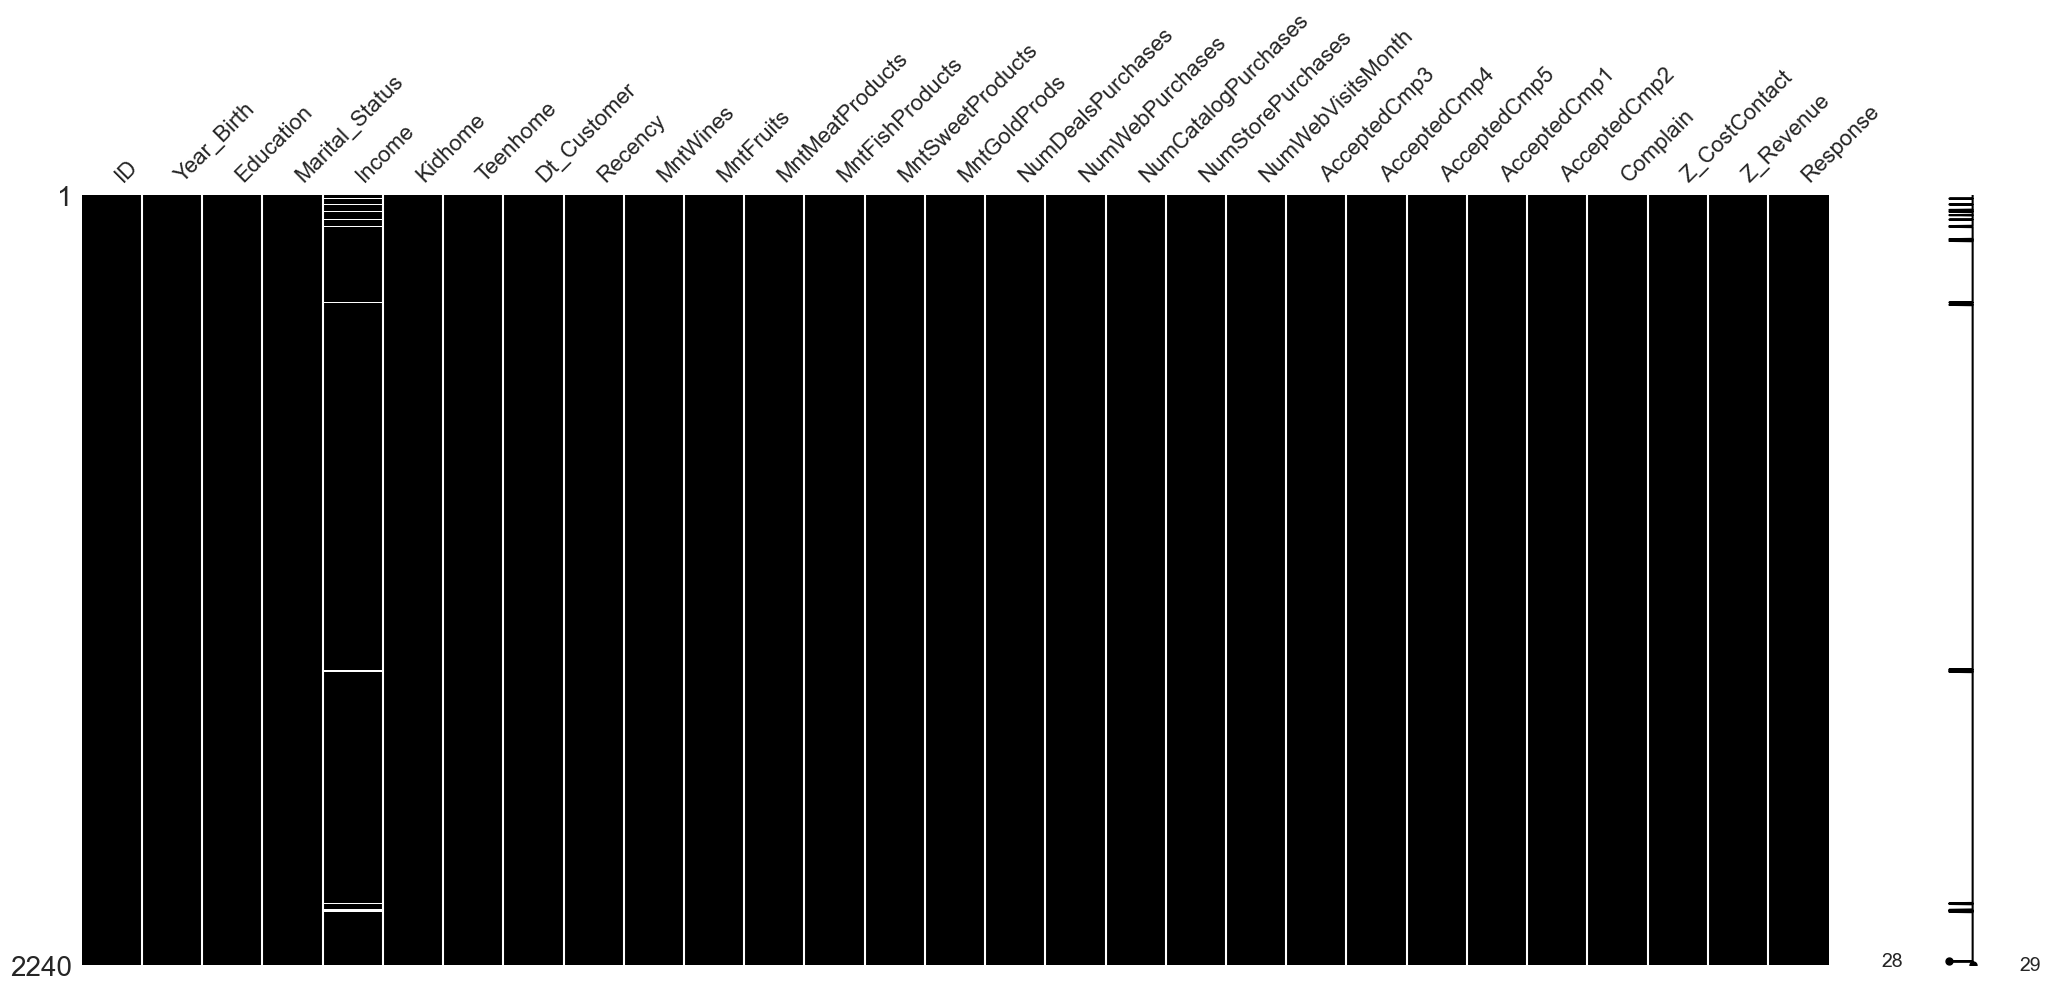

In [7]:
# Visualizar a matriz de valores ausentes
print("\n\n--- Matriz de Valores Ausentes ---")
mn.matrix(df,color = (0,0,0))

###  Verificação de Linhas Duplicadas

In [8]:
num_duplicados = df.duplicated().sum()
print(f"Número de linhas duplicadas encontradas: {num_duplicados}")

Número de linhas duplicadas encontradas: 0


### Contagem de Valores Únicos (Cardinalidade) por Coluna

O `.nunique()` é essencial para identificar colunas constantes.

In [9]:
display(df.nunique())

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

A análise de cardinalidade revelou que as colunas `Z_CostContact` e `Z_Revenue` possuem apenas **1 valor único**. Elas são constantes e serão removidas na etapa de limpeza por não adicionarem informação útil.

### Conclusão da Análise Diagnóstica

A partir da análise diagnóstica, podemos extrair as seguintes conclusões que guiarão nosso próximo passo:

* **Estrutura Confirmada:** O dataset possui **2240 linhas** e **29 colunas**.
* **Dados Ausentes Identificados:** O diagnóstico confirma que a única coluna com valores faltantes é a `Income`, com **24 registros nulos**.
* **Sem Duplicatas:** Não há linhas duplicadas no dataset.
* **Colunas Constantes:** As colunas `Z_CostContact` e `Z_Revenue` possuem apenas um valor único, indicando que não contribuem com informação útil para a clusterização. Elas serão removidas na etapa de limpeza.
* **Necessidade de Pré-processamento:** O dataset contém uma mistura de tipos de dados (numéricos e de texto) que exigirá tratamento (normalização e codificação) antes da modelagem.

# Data Cleaning

In [10]:
df_clean = df.copy()

### Preenchimento de Dados Ausentes

Para lidar com os dados ausentes, uma abordagem comum é preencher os valores nulos com a mediana da coluna correspondente. Isso é especialmente útil para colunas numéricas, como a `Income`, onde a média pode fornecer uma estimativa razoável do valor ausente sem introduzir viés significativo.

In [11]:
income_median = df_clean['Income'].median()
df_clean['Income'].fillna(income_median, inplace=True)
print(f"Valores nulos em 'Income' após imputação: {df_clean['Income'].isnull().sum()}")

Valores nulos em 'Income' após imputação: 0


### Engenharia de Features
A engenharia de features é uma etapa crucial no pré-processamento de dados, onde transformamos e criamos novas variáveis a partir das existentes para melhorar o desempenho dos modelos de Machine Learning.

In [12]:
# CRIAÇÃO DE FEATURES

# Criação da Feature 'Age' a partir do ano de nascimento
df_clean['Age'] = 2025 - df_clean['Year_Birth']

# Criação da Feature 'Total_Spent' que soma os gastos em diferentes categorias
df_clean['Total_Spent'] = df_clean[[col for col in df.columns if 'Mnt' in col]].sum(axis=1)

# Conversão da coluna 'Dt_Customer' para o formato datetime
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], dayfirst=True)

# Criação da Feature 'Customer_Tenure' que calcula o tempo de relacionamento com o cliente
df_clean['Customer_Tenure'] = (pd.to_datetime('2025-07-06') - df_clean['Dt_Customer']).dt.days # Usando a data da entrega

# Criação da Feature 'Children' que soma as colunas 'Kidhome' e 'Teenhome'
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

# Criação da Feature 'Is_Parent' que indica se o cliente é pai/mãe
df_clean['Is_Parent'] = np.where(df_clean['Children'] > 0, 1, 0)

In [13]:
# SIMPLIFICAÇÃO DE FEATURES

# Simplificação da coluna 'Marital_Status', a fim de agrupar estados civis semelhantes.
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace({
    'Married': 'In_Relationship',
    'Together': 'In_Relationship',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
})

# Simplificação da coluna 'Education', agrupando níveis de escolaridade semelhantes.
df_clean['Education'] = df_clean['Education'].replace({
    'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Graduate',
    'Master': 'Postgraduate', 'PhD': 'Postgraduate'
})

# Criação de Feature Combinada
df_clean['Family_Size'] = df_clean['Marital_Status'].map({'Single': 1, 'In_Relationship': 2}) + df_clean['Children']

In [14]:
# REMOÇÃO DE FEATURES INÚTEIS

to_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']
df_clean.drop(columns=to_drop, inplace=True)
print(f"\nColunas removidas do dataset: {to_drop}")


Colunas removidas do dataset: ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']


In [15]:
# --- TRADUÇÃO DAS COLUNAS PARA PORTUGUÊS ---

# Dicionário mapeando os nomes originais para os nomes em português
mapeamento_nomes = {
    'Education': 'Escolaridade',
    'Marital_Status': 'Estado_Civil',
    'Income': 'Renda_Anual',
    'Recency': 'Dias_Ultima_Compra',
    'MntWines': 'Gasto_Vinhos',
    'MntFruits': 'Gasto_Frutas',
    'MntMeatProducts': 'Gasto_Carnes',
    'MntFishProducts': 'Gasto_Peixes',
    'MntSweetProducts': 'Gasto_Doces',
    'MntGoldProds': 'Gasto_Ouro',
    'NumDealsPurchases': 'Compras_com_Desconto',
    'NumWebPurchases': 'Compras_pela_Web',
    'NumCatalogPurchases': 'Compras_por_Catalogo',
    'NumStorePurchases': 'Compras_na_Loja',
    'NumWebVisitsMonth': 'Visitas_no_Site_Mes',
    'AcceptedCmp3': 'Aceitou_Campanha_3',
    'AcceptedCmp4': 'Aceitou_Campanha_4',
    'AcceptedCmp5': 'Aceitou_Campanha_5',
    'AcceptedCmp1': 'Aceitou_Campanha_1',
    'AcceptedCmp2': 'Aceitou_Campanha_2',
    'Complain': 'Reclamou_2_Anos',
    'Response': 'Aceitou_Ultima_Campanha',
    'Age': 'Idade',
    'Total_Spent': 'Gasto_Total',
    'Customer_Tenure': 'Tempo_de_Cliente_dias',
    'Children': 'Total_Filhos',
    'Is_Parent': 'Possui_Filhos',
    'Family_Size': 'Tamanho_Familia'
}

df_clean.rename(columns=mapeamento_nomes, inplace=True)

print("\n--- Colunas traduzidas para o português ---")
print("Visualizando o dataframe com os novos nomes de colunas:")
display(df_clean.head())


--- Colunas traduzidas para o português ---
Visualizando o dataframe com os novos nomes de colunas:


,Escolaridade,Estado_Civil,Renda_Anual,Dias_Ultima_Compra,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Ouro,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Reclamou_2_Anos,Aceitou_Ultima_Campanha,Idade,Gasto_Total,Tempo_de_Cliente_dias,Total_Filhos,Possui_Filhos,Tamanho_Familia
0,Graduate,Single,58138.0,58,635,88,546,172,88,88,...,0,0,0,1,68,1617,4688,0,0,1
1,Graduate,Single,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,71,27,4138,2,1,3
2,Graduate,In_Relationship,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,60,776,4337,0,0,2
3,Graduate,In_Relationship,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,41,53,4164,1,1,3
4,Postgraduate,In_Relationship,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,44,422,4186,1,1,3


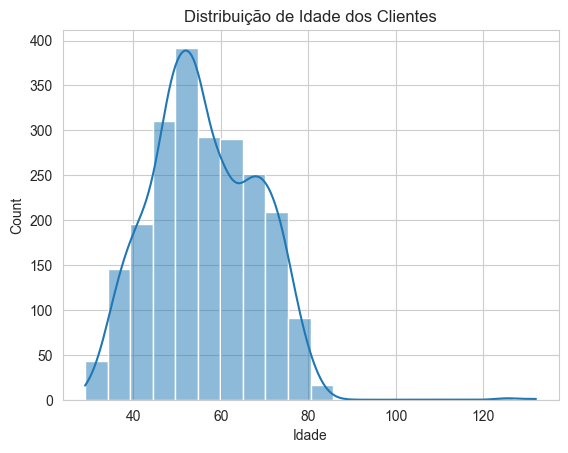

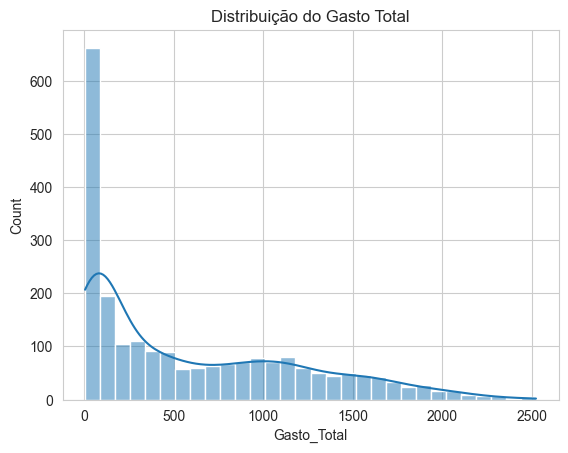

In [16]:
# Verificar distribuição de idade
sns.histplot(df_clean['Idade'], bins=20, kde=True)
plt.title('Distribuição de Idade dos Clientes')
plt.show()

# Gasto Total
sns.histplot(df_clean['Gasto_Total'], bins=30, kde=True)
plt.title('Distribuição do Gasto Total')
plt.show()